In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn import preprocessing
warnings.filterwarnings("ignore")

In [2]:
ownership = pd.read_csv('Ownership_Investment_2020.csv')
research = pd.read_csv('Research_Payments_2020.csv')
general = pd.read_csv('General_Payments_2020.csv', parse_dates=['Date_of_Payment', 'Payment_Publication_Date'], 
                     dtype={'Teaching_Hospital_CCN': np.float32,'Teaching_Hospital_ID': np.float16, 'Physician_Profile_ID' : np.float32, 'Total_Amount_of_Payment_USDollars': np.float32, 'Number_of_Payments_in_Total_Amount': np.int16, 'Record_ID': np.int32})

list_str_obj_cols = general.columns[general.dtypes == "object"].tolist()
for str_obj_col in list_str_obj_cols:
    general[str_obj_col] = general[str_obj_col].astype("category")

# Some simple EDAs and visualization

In [3]:
payment_by_states = general.groupby(by='Recipient_State').sum().sort_values('Total_Amount_of_Payment_USDollars', ascending=False)['Total_Amount_of_Payment_USDollars']

In [4]:
payment_by_states = pd.DataFrame(payment_by_states)

<AxesSubplot:xlabel='Recipient_State'>

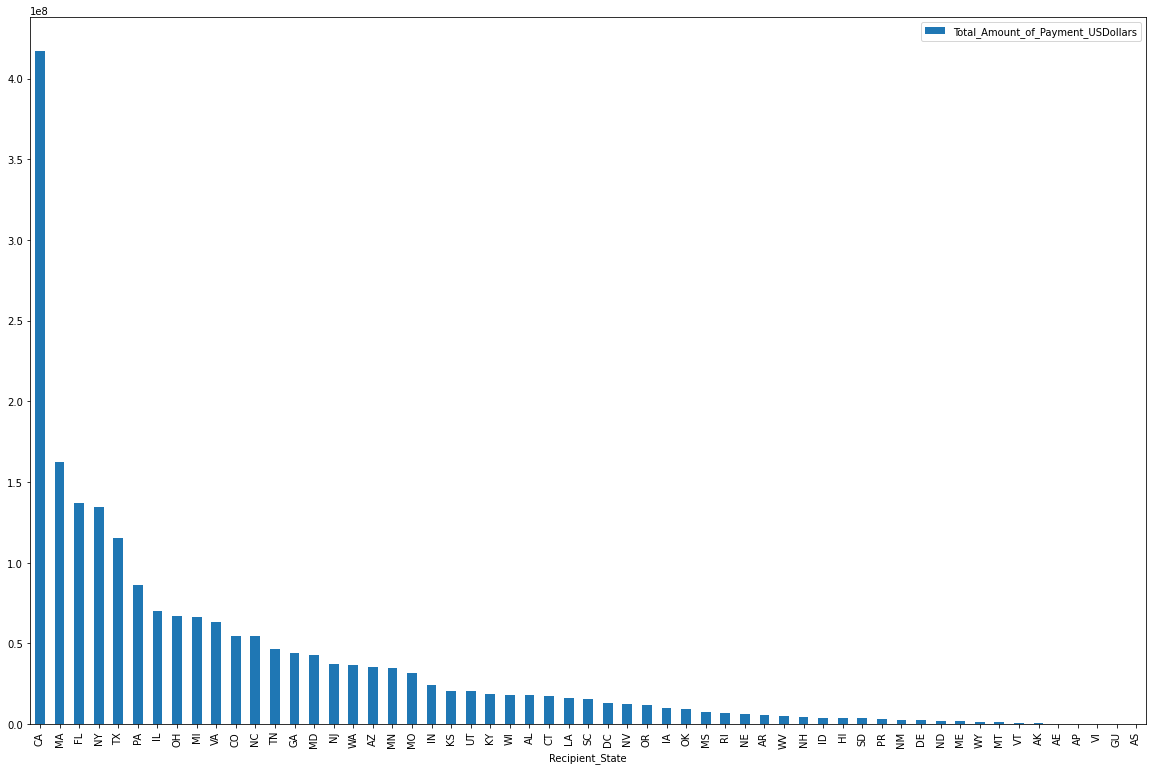

In [5]:
payment_by_states.plot(kind='bar', figsize=(20,13))

In [64]:
general_copy = general[['Recipient_State', 'Physician_Primary_Type', 'Physician_Specialty', 'Total_Amount_of_Payment_USDollars', 'Number_of_Payments_in_Total_Amount']]
general_copy.isna().sum()

Recipient_State                         235
Physician_Primary_Type                31855
Physician_Specialty                   31995
Total_Amount_of_Payment_USDollars         0
Number_of_Payments_in_Total_Amount        0
dtype: int64

In [65]:
le = preprocessing.LabelEncoder()
temp = le.fit(general_copy.Recipient_State)
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

general_copy.Recipient_State = temp.transform(general_copy.Recipient_State)
general_copy

{'AE': 0, 'AK': 1, 'AL': 2, 'AP': 3, 'AR': 4, 'AS': 5, 'AZ': 6, 'CA': 7, 'CO': 8, 'CT': 9, 'DC': 10, 'DE': 11, 'FL': 12, 'GA': 13, 'GU': 14, 'HI': 15, 'IA': 16, 'ID': 17, 'IL': 18, 'IN': 19, 'KS': 20, 'KY': 21, 'LA': 22, 'MA': 23, 'MD': 24, 'ME': 25, 'MI': 26, 'MN': 27, 'MO': 28, 'MS': 29, 'MT': 30, 'NC': 31, 'ND': 32, 'NE': 33, 'NH': 34, 'NJ': 35, 'NM': 36, 'NV': 37, 'NY': 38, 'OH': 39, 'OK': 40, 'OR': 41, 'PA': 42, 'PR': 43, 'RI': 44, 'SC': 45, 'SD': 46, 'TN': 47, 'TX': 48, 'UT': 49, 'VA': 50, 'VI': 51, 'VT': 52, 'WA': 53, 'WI': 54, 'WV': 55, 'WY': 56, nan: 57}


,Recipient_State,Physician_Primary_Type,Physician_Specialty,Total_Amount_of_Payment_USDollars,Number_of_Payments_in_Total_Amount
0,38,Medical Doctor,Allopathic & Osteopathic Physicians|Pain Medic...,14875.000000,1
1,38,Doctor of Dentistry,Dental Providers|Dentist,5296.000000,1
2,18,Doctor of Dentistry,Dental Providers|Dentist,1050.000000,1
3,27,Medical Doctor,Allopathic & Osteopathic Physicians|Orthopaedi...,4750.000000,1
4,35,Chiropractor,Chiropractic Providers|Chiropractor,320.000000,1
...,...,...,...,...,...
5767197,36,Medical Doctor,Allopathic & Osteopathic Physicians|Plastic Su...,107.699997,1
5767198,36,Medical Doctor,Allopathic & Osteopathic Physicians|Plastic Su...,4500.000000,1
5767199,36,Medical Doctor,Allopathic & Osteopathic Physicians|Plastic Su...,40.130001,1
5767200,36,Medical Doctor,Allopathic & Osteopathic Physicians|Plastic Su...,666.580017,1


In [66]:
le_2 = preprocessing.LabelEncoder()
temp_2 = le_2.fit(general_copy.Physician_Primary_Type)
le_name_mapping_2 = dict(zip(le_2.classes_, le_2.transform(le_2.classes_)))
print(le_name_mapping_2)

general_copy.Physician_Primary_Type = temp_2.transform(general_copy.Physician_Primary_Type)
general_copy

{'Chiropractor': 0, 'Doctor of Dentistry': 1, 'Doctor of Optometry': 2, 'Doctor of Osteopathy': 3, 'Doctor of Podiatric Medicine': 4, 'Medical Doctor': 5, nan: 6}


,Recipient_State,Physician_Primary_Type,Physician_Specialty,Total_Amount_of_Payment_USDollars,Number_of_Payments_in_Total_Amount
0,38,5,Allopathic & Osteopathic Physicians|Pain Medic...,14875.000000,1
1,38,1,Dental Providers|Dentist,5296.000000,1
2,18,1,Dental Providers|Dentist,1050.000000,1
3,27,5,Allopathic & Osteopathic Physicians|Orthopaedi...,4750.000000,1
4,35,0,Chiropractic Providers|Chiropractor,320.000000,1
...,...,...,...,...,...
5767197,36,5,Allopathic & Osteopathic Physicians|Plastic Su...,107.699997,1
5767198,36,5,Allopathic & Osteopathic Physicians|Plastic Su...,4500.000000,1
5767199,36,5,Allopathic & Osteopathic Physicians|Plastic Su...,40.130001,1
5767200,36,5,Allopathic & Osteopathic Physicians|Plastic Su...,666.580017,1


In [67]:
le_3 = preprocessing.LabelEncoder()
temp_3 = le_3.fit(general_copy.Physician_Specialty)
le_name_mapping_3 = dict(zip(le_3.classes_, le_3.transform(le_3.classes_)))
print(le_name_mapping_3)

general_copy.Physician_Specialty = temp_3.transform(general_copy.Physician_Specialty)
general_copy

{'Allopathic & Osteopathic Physicians|Allergy & Immunology': 0, 'Allopathic & Osteopathic Physicians|Allergy & Immunology|Allergy': 1, 'Allopathic & Osteopathic Physicians|Allergy & Immunology|Clinical & Laboratory Immunology': 2, 'Allopathic & Osteopathic Physicians|Anesthesiology': 3, 'Allopathic & Osteopathic Physicians|Anesthesiology|Addiction Medicine': 4, 'Allopathic & Osteopathic Physicians|Anesthesiology|Critical Care Medicine': 5, 'Allopathic & Osteopathic Physicians|Anesthesiology|Hospice and Palliative Medicine': 6, 'Allopathic & Osteopathic Physicians|Anesthesiology|Pain Medicine': 7, 'Allopathic & Osteopathic Physicians|Anesthesiology|Pediatric Anesthesiology': 8, 'Allopathic & Osteopathic Physicians|Clinical Pharmacology': 9, 'Allopathic & Osteopathic Physicians|Colon & Rectal Surgery': 10, 'Allopathic & Osteopathic Physicians|Dermatology': 11, 'Allopathic & Osteopathic Physicians|Dermatology|Clinical & Laboratory Dermatological Immunology': 12, 'Allopathic & Osteopathic 

,Recipient_State,Physician_Primary_Type,Physician_Specialty,Total_Amount_of_Payment_USDollars,Number_of_Payments_in_Total_Amount
0,38,5,114,14875.000000,1
1,38,1,237,5296.000000,1
2,18,1,237,1050.000000,1
3,27,5,98,4750.000000,1
4,35,0,223,320.000000,1
...,...,...,...,...,...
5767197,36,5,164,107.699997,1
5767198,36,5,164,4500.000000,1
5767199,36,5,164,40.130001,1
5767200,36,5,164,666.580017,1


# Outlier Algorithms

### Simple function to make predicting and visualizing outliers easier with the isolation forest algo

In [71]:
"""
What the inputs refer to 

dataset - which dataset do you wish to analyze
state - which state do you wish to analyze
column_to_plot - which column do you wish the y-axis to show you 
n_estimators - hyperparam for isolationforest 
contamination - another hyperparam; the higher the number, the more outliers / the more lenient the model would be 
"""

def isolationforestoutlier(dataset, state, column_to_plot, n_estimators=200, contamination=0.01):
    dataset = dataset.where(dataset['Recipient_State'] == state)
    dataset.dropna(subset=['Recipient_State'], inplace=True)
    dataset = dataset.sort_values(column_to_plot, ascending=False)

    input_matrix = np.array(dataset[column_to_plot]).reshape(-1,1)
        
    print("Predicting\n")
    model = IsolationForest(n_estimators = n_estimators, contamination = contamination, n_jobs=-1, random_state = 42).fit(input_matrix)
    result = model.predict(input_matrix)
    print("Finished predicting\n")
    print("Checking for outliers\n")
    temp = result == -1 # Checking for outliers
    index = [] 
    for i in range(len(temp)):
        if temp[i] == True:
            index.append(i)
    indexs = [] # List containing the index of outliers
    for value in index:
        indexs.append(dataset[column_to_plot].index[value])
    
    print("We have {} outliers in total\n".format(len(indexs)))
    print("{:.2}% are outliers in this dataset\n".format(len(indexs)/len(dataset)))
    
    print("The indexes of the outliers are" , indexs)
    #print(pd.DataFrame(dataset.loc[indexs])) # Uncomment if you wish to visualize the outliers
        
    print("\n Plotting graph now\n")
    # Plotting
    x_1 = [] # Outliers
    y_1 = []
    for value in indexs:
        x_1.append(value)
        y_1.append(dataset[column_to_plot][value])
        dataset.drop(value, inplace=True)

    fig = plt.figure(figsize=(15, 10), dpi=80)
    plt.title("In {}".format(state))
    plt.xlabel('Index')
    plt.ylabel('{}'.format(column_to_plot))
    ax1 = fig.add_subplot()

    ax1.scatter(x=x_1, y=y_1, s=10, c='r', label='Outliers')
    ax1.scatter(x=dataset.index, y=dataset[column_to_plot], s=10, c='b', label='Inliers')
    plt.legend(loc='upper left')
    plt.show()

# Multi-Dimensional Isolation Forest Algo

In [79]:
input_matrix = np.array(general_copy)

In [81]:
model = IsolationForest(n_estimators = 200,contamination = 0.001, n_jobs=-1, random_state = 42).fit(input_matrix)
result = model.predict(input_matrix)

In [100]:
temp = result == -1 # Checking for outliers
index = [] 
for i in range(len(temp)):
    if temp[i] == True:
        index.append(i)

### The rows from the general_payments dataset that are classified as outliers

In [113]:
outlier_general_copy = general_copy.loc[index]
outlier_general_copy

,Recipient_State,Physician_Primary_Type,Physician_Specialty,Total_Amount_of_Payment_USDollars,Number_of_Payments_in_Total_Amount
25,20,5,132,606998.000000,13
30,39,2,251,183105.500000,14
33,39,2,251,24000.000000,12
36,50,6,271,3096.000000,6
97,7,1,246,25000.000000,1
...,...,...,...,...,...
5764851,48,6,271,15000.000000,1
5764852,38,6,271,189000.000000,1
5764853,42,6,271,26587.070312,1
5764868,7,6,271,334928.781250,1


In [114]:
outlier_general_copy.Recipient_State = le.inverse_transform(outlier_general_copy.Recipient_State)
outlier_general_copy.Physician_Primary_Type = le_2.inverse_transform(outlier_general_copy.Physician_Primary_Type)
outlier_general_copy.Physician_Specialty = le_3.inverse_transform(outlier_general_copy.Physician_Specialty)

In [120]:
outlier_general_copy.sort_values(by='Total_Amount_of_Payment_USDollars', ascending=False)[:20]

,Recipient_State,Physician_Primary_Type,Physician_Specialty,Total_Amount_of_Payment_USDollars,Number_of_Payments_in_Total_Amount
3435665,CA,NaN,NaN,9800015.0,1
3435660,CA,NaN,NaN,9205620.0,1
3435658,CA,NaN,NaN,8358713.0,1
3435630,CA,NaN,NaN,8121447.5,1
1475961,MA,NaN,NaN,8057036.5,1
3435663,CA,NaN,NaN,7946206.0,1
2596809,MA,NaN,NaN,7756092.0,1
3435692,MA,NaN,NaN,7700155.5,1
1433467,MA,NaN,NaN,7477826.5,1
2299902,VA,Medical Doctor,Allopathic & Osteopathic Physicians|Radiology|...,7466056.5,1


### The rows of general dataset classified as outliers from multidimensional input

In [140]:
general.loc[list(outlier_general_copy.index)].sort_values(by='Total_Amount_of_Payment_USDollars', ascending=False)[['Teaching_Hospital_Name', 'Physician_Profile_ID', 'Recipient_State', 'Manufacturer_or_GPO_State', 'Manufacturer_or_GPO_Name']][:20]

,Teaching_Hospital_Name,Physician_Profile_ID,Recipient_State,Manufacturer_or_GPO_State,Manufacturer_or_GPO_Name
3435665,CITY OF HOPE NATIONAL MEDICAL CTR,NaN,CA,CA,"Genentech, Inc."
3435660,CITY OF HOPE NATIONAL MEDICAL CTR,NaN,CA,CA,"Genentech, Inc."
3435658,CITY OF HOPE NATIONAL MEDICAL CTR,NaN,CA,CA,"Genentech, Inc."
3435630,CITY OF HOPE NATIONAL MEDICAL CTR,NaN,CA,CA,"Genentech, Inc."
1475961,Dana-Farber Cancer Institute,NaN,MA,DE,AstraZeneca Pharmaceuticals LP
3435663,CITY OF HOPE NATIONAL MEDICAL CTR,NaN,CA,CA,"Genentech, Inc."
2596809,Dana-Farber Cancer Institute,NaN,MA,DE,AstraZeneca Pharmaceuticals LP
3435692,DANA-FARBER CANCER INSTITUTE,NaN,MA,CA,"Genentech, Inc."
1433467,Dana-Farber Cancer Institute,NaN,MA,DE,AstraZeneca Pharmaceuticals LP
2299902,NaN,268146.0,VA,MN,"Medtronic Vascular, Inc."


### Some examples of the function

Predicting

Finished predicting

Checking for outliers

We have 50 outliers in total

8.3e-05% are outliers in this dataset

The indexes of the outliers are [1110073, 3435665, 3435660, 3435658, 3435630, 3435663, 1110093, 3435627, 957139, 957134, 1110072, 3435606, 3435596, 3435609, 3435636, 957137, 1110089, 3435580, 3435633, 3435629, 2299906, 3435575, 3435612, 3435588, 3435712, 3435628, 3435569, 3435551, 3435632, 1110074, 3559951, 3435567, 3435555, 3435585, 4653626, 3435591, 3435577, 3559966, 3559968, 3435579, 3435639, 3435562, 957135, 1110094, 3435572, 3435634, 4559259, 3435642, 3559967, 1110071]

 Plotting graph now



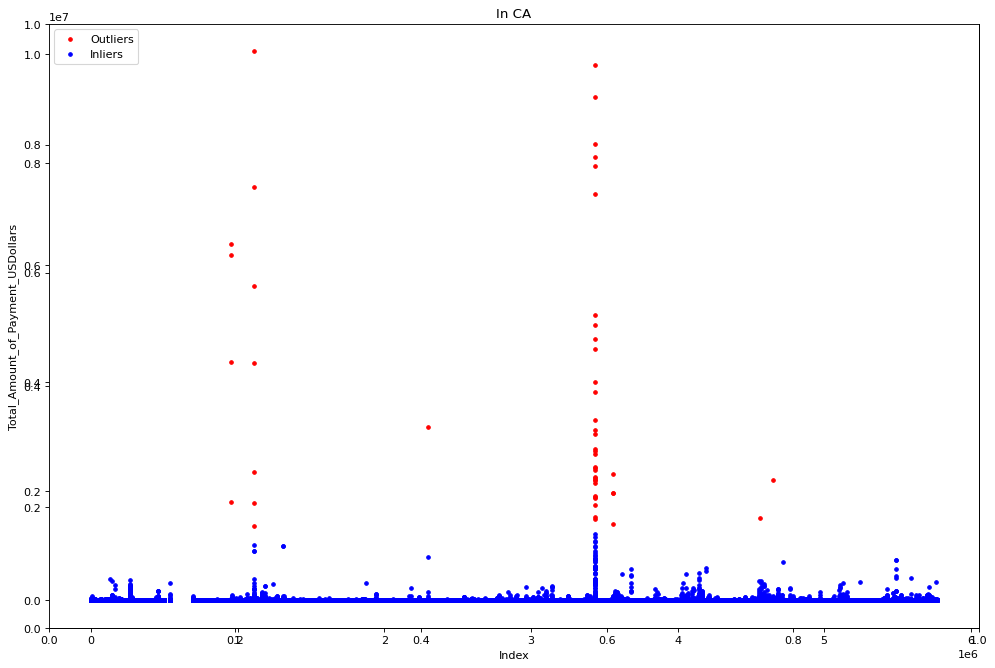

In [72]:
isolationforestoutlier(general, 'CA', 'Total_Amount_of_Payment_USDollars', 200, 0.0001)

In [ ]:
isolationforestoutlier(ownership, 'CA', 'Value_of_Interest', 200, 0.01)

### Some simple analysis

In [ ]:
general_ca = general.where(general['Recipient_State'] == 'CA')
general_ca.dropna(subset=['Recipient_State'], inplace=True)
general_ca = general_ca.sort_values('Total_Amount_of_Payment_USDollars', ascending=False)

general_ca_copy = general_ca.copy()

for value in [1110073, 3435665, 3435660, 3435658, 3435630, 3435663, 1110093, 3435627, 957139, 957134, 1110072, 3435606, 3435596, 3435609, 3435636, 957137, 1110089, 3435580, 3435633, 3435629, 2299906, 3435575, 3435612, 3435588, 3435712, 3435628, 3435569, 3435551, 3435632, 1110074, 3559951, 3435567, 3435555, 3435585, 4653626, 3435591, 3435577, 3559966, 3559968, 3435579, 3435639, 3435562, 957135, 1110094, 3435572, 3435634, 4559259, 3435642, 3559967, 1110071, 3435644, 3435669, 3435664, 3435662, 1110090, 1312014, 1312010, 3435650, 3435667]:
    general_ca_copy.drop(value, inplace=True)
    
temp = pd.DataFrame(general_ca_copy['Total_Amount_of_Payment_USDollars'])
plt.figure(figsize=(10, 10), dpi=80)
sns.distplot(temp)

In [ ]:
general_ca.loc[[1110073, 3435665, 3435660, 3435658, 3435630, 3435663, 1110093, 3435627, 957139, 957134, 1110072, 3435606, 3435596, 3435609, 3435636, 957137, 1110089, 3435580, 3435633, 3435629, 2299906, 3435575, 3435612, 3435588, 3435712, 3435628, 3435569, 3435551, 3435632, 1110074, 3559951, 3435567, 3435555, 3435585, 4653626, 3435591, 3435577, 3559966, 3559968, 3435579, 3435639, 3435562, 957135, 1110094, 3435572, 3435634, 4559259, 3435642, 3559967, 1110071, 3435644, 3435669, 3435664, 3435662, 1110090, 1312014, 1312010, 3435650, 3435667]]['Product_Category_or_Therapeutic_Area_1'].unique().to_list()